# Benchamrking and testing scVI

**Authorship:**
Adam Klie, *02/23/2022*
***
**Description:**
Notebook for benchmarking scVI on simulated dataset

<div class="alert alert-block alert-warning">
<b>TODOs</b>:
<ul>
    <b><li>Sort out what is happening with PCA</li></b>
    <b><li></li></b>
    <b><li></li></b>
    <b><li></li></b>
    </ul>
</div>

# Set-up

In [149]:
# The classics
import pandas as pd

# Single cell tools
import scvi
import scanpy as sc

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [150]:
import torch
torch.cuda.is_available()

True

# Load a dataset

In [151]:
counts = pd.read_csv("simulated/counts.6.2000.200.1.tsv", sep="\t")
truecounts = pd.read_csv("simulated/truecounts.6.2000.200.1.tsv", sep="\t")
geneinfo = pd.read_csv("simulated/geneinfo.6.2000.200.1.tsv", sep="\t")
cellinfo = pd.read_csv("simulated/cellinfo.6.2000.200.1.tsv", sep="\t")

In [152]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'

In [153]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

# Preprocess

In [155]:
sc.pp.normalize_total(adata)
sc.pp.normalize_total(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

# Creating and Training a Model

In [156]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 2000 cells, 198 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [157]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 400/400: 100%|██████████| 400/400 [00:40<00:00,  9.96it/s, loss=808, v_num=1]


In [159]:
adata_ae = sc.AnnData(model.get_normalized_expression(), obs=cellinfo, var=adata.var)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = adata.var_names
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'

In [160]:
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

# Observing model outputs

... storing 'Batch' as categorical
... storing 'Group' as categorical


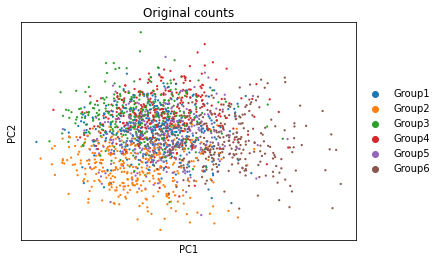

... storing 'Batch' as categorical
... storing 'Group' as categorical


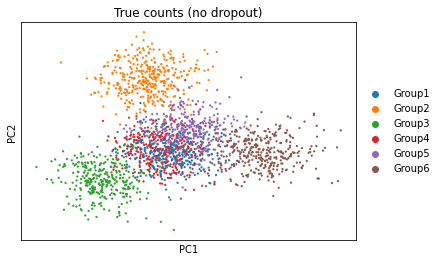

... storing 'Batch' as categorical
... storing 'Group' as categorical


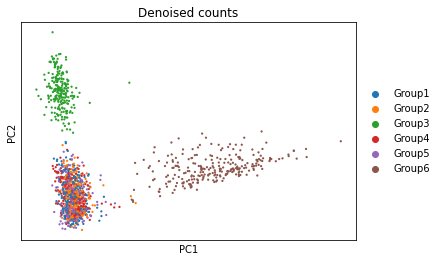

In [161]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

In [162]:
# run PCA then generate UMAP plots
sc.tl.tsne(adata)
sc.tl.tsne(adata_true)
sc.tl.tsne(adata_ae)

/cellar/users/aklie/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/cellar/users/aklie/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/cellar/users/aklie/opt/miniconda3/envs/scvi-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


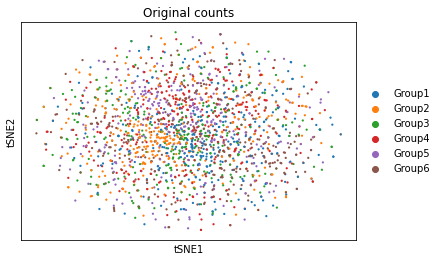

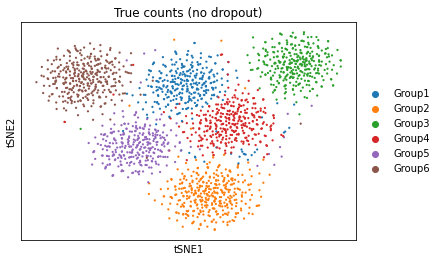

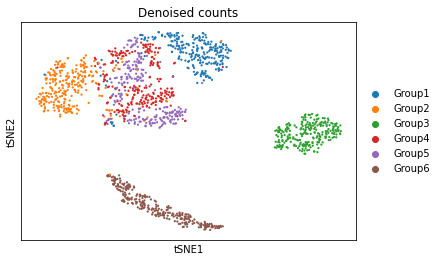

In [163]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

# References

1. [API Overview](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html)